# Adaptive LDA Augmented Rule

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Rules import GameRules
from LDA_adaptive import aLDA
from LDA_adaptive import print_array, load_data

## Augmented Rule

In [2]:
all_IDs = ["ID#31127011_2WProsthUse", "ID#31180011_2WProsthUse", "ID#32068222_2WProsthUse", 
               "ID#32098021_2WProsthUse", "ID#32132721_2WProsthUse_KW", "ID#32136722_2WProsthUse",
               "ID#32195432_2WProsthUse", "ID#51013322_2WProsthUse", "ID#51048532_2WProsthUse", 
               "ID#52054922_2WProsthUse"]

""" Read in all In the Zone game data for one subject"""
""" Prime subjects: ID#32068222_2WProsthUse(2), ID#32136722_2WProsthUse(5), ID#51048532_2WProsthUse(8), ID#52054922_2WProsthUse(9)"""
Gamedata = load_data(all_IDs[2])
print(f"Total games: {len(Gamedata)}")

Game data paths:
/home/androo/Documents/Coapt/Code/../Data/ID#32068222_2WProsthUse/VirtualGameData/VirtualArmGames_-4_28_2021_17_42_11.csv
/home/androo/Documents/Coapt/Code/../Data/ID#32068222_2WProsthUse/VirtualGameData/VirtualArmGames_-4_29_2021_20_12_50.csv
/home/androo/Documents/Coapt/Code/../Data/ID#32068222_2WProsthUse/VirtualGameData/VirtualArmGames_-4_30_2021_16_19_22.csv
/home/androo/Documents/Coapt/Code/../Data/ID#32068222_2WProsthUse/VirtualGameData/VirtualArmGames_-5_10_2021_17_15_55.csv
/home/androo/Documents/Coapt/Code/../Data/ID#32068222_2WProsthUse/VirtualGameData/VirtualArmGames_-5_11_2021_19_57_6.csv
/home/androo/Documents/Coapt/Code/../Data/ID#32068222_2WProsthUse/VirtualGameData/VirtualArmGames_-5_1_2021_18_2_58.csv
/home/androo/Documents/Coapt/Code/../Data/ID#32068222_2WProsthUse/VirtualGameData/VirtualArmGames_-5_2_2021_21_51_1.csv
/home/androo/Documents/Coapt/Code/../Data/ID#32068222_2WProsthUse/VirtualGameData/VirtualArmGames_-5_3_2021_18_45_31.csv
/home/androo/

### Process data to add in no motion targets based off of saved class means

In [3]:
classmeans = pd.read_csv("../Data/ID#52054922_2WProsthUse/VirtualGameData/ClassMeans-2_18_2021_9_59_6.csv",header=None).to_numpy()
# first array is for 0
classmeans = classmeans[:,1:]
classmeans = classmeans[:, 0::7]
noMotion_thresh = 1.1 * np.mean(classmeans[0])
print(f"No motion threshold: {noMotion_thresh}")

for file in Gamedata:
    counter = 0
    for ind in file.index:
        curr_mean = file[['emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].iloc[counter].mean()
        if curr_mean < noMotion_thresh:
            file.at[ind, 'targetClass'] = 0
        counter += 1
    print(f"Number of no motions: {np.sum(file['targetClass'] == 0)}")

No motion threshold: 647.8246452331543
Number of no motions: 1162
Number of no motions: 1247
Number of no motions: 738
Number of no motions: 413
Number of no motions: 850
Number of no motions: 767
Number of no motions: 607
Number of no motions: 701
Number of no motions: 921
Number of no motions: 1301
Number of no motions: 812
Number of no motions: 690
Number of no motions: 819


### First virtual game data

In [4]:
unadapted_err = []
adapted_err = []
adapted_wrules_err = []
baseline = []

class_data = Gamedata[0][['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
print("Error Rates")
print(f"First game baseline: {init_err}%")
baseline.append(init_err)

""" Unadapted """
X = class_data[:, 2:]
y = class_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

lda = aLDA()
_, _ = lda.fit(X, y, flag=0)

X = test_sample[:, :-1]
y = test_sample[:, -1]
lda_preds = lda.predict(X)

# print_array(y)
# print_array(lda_preds)

print(f"First game unadapted: {np.around((y!=lda_preds).sum() / y.size, 2) * 100}%")

unadapted_err.append(np.around((y!=lda_preds).sum() / y.size, 2) * 100)

""" Adapted """ 
X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

alda_norules = aLDA()
prev_means_norules, prev_covs_norules = alda_norules.fit(X, y, flag=0)

X = test_sample[:, :-1]
y = test_sample[:, -1]
alda_norules_preds = alda_norules.predict(X)

print(f"First game adapted: {np.around((y!=alda_norules_preds).sum() / y.size, 2) * 100}%")

adapted_err.append(np.around((y!=alda_norules_preds).sum() / y.size, 2) * 100)

""" Adapted with rules """
rules = GameRules()
new_data = rules.base_rule(Gamedata[0])
new_data = np.vstack((new_data))[:,:-1]

X = new_data[:, 2:]
y = new_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

alda = aLDA()
prev_means, prev_covs = alda.fit(X, y, flag=0)

X = test_sample[:, :-1]
y = test_sample[:, -1]
alda_preds = alda.predict(X)

# print_array(y)
# print_array(alda_preds)
print(f"First game adapted w/ rules: {np.around((y!=alda_preds).sum() / y.size, 2) * 100}%")

adapted_wrules_err.append(np.around((y!=alda_preds).sum() / y.size, 2) * 100)

Error Rates
First game baseline: 36.0%
First game unadapted: 22.0%
First game adapted: 22.0%
First game adapted w/ rules: 24.0%


### Second virtual game data

In [5]:
class_data = Gamedata[1][['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
print(f"Second game baseline: {init_err}%")
baseline.append(init_err)

X = class_data[:, 2:]
y = class_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

"""Test without adapting"""
X = test_sample[:, :-1]
y = test_sample[:, -1]

preds = lda.predict(X)
print(f"Second game unadapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

unadapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

""" Test with adaptation """
X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means_norules:
    meanMat = prev_means_norules[key]
    covMat = prev_covs_norules[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means_norules[key], prev_covs_norules[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means_norules, prev_covs_norules = alda.fit(X, y, classmeans=prev_means_norules, covariance=prev_covs_norules, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda_norules.predict(X)
print(f"Second game adapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

"""Test with adaptation and rules"""
rules = GameRules()
new_data = rules.base_rule(Gamedata[1])
new_data = np.vstack((new_data))[:,:-1]

X = new_data[:, 2:]
y = new_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means:
    meanMat = prev_means[key]
    covMat = prev_covs[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means[key], prev_covs[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means, prev_covs = alda.fit(X, y, classmeans=prev_means, covariance=temp_covs, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda.predict(X)
print(f"Second game adapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

Second game baseline: 40.0%
Second game unadapted: 25.0%
Second game adapted: 26.0%
Second game adapted w/ rules: 24.0%


### Third virtual game data

In [6]:
class_data = Gamedata[2][['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
print(f"Third game baseline: {init_err}%")
baseline.append(init_err)

X = class_data[:, 2:]
y = class_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

"""Test without adapting"""
X = test_sample[:, :-1]
y = test_sample[:, -1]

preds = lda.predict(X)
print(f"Third game unadapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

unadapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

""" Test with adaptation """
X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means_norules:
    meanMat = prev_means_norules[key]
    covMat = prev_covs_norules[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means_norules[key], prev_covs_norules[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means_norules, prev_covs_norules = alda.fit(X, y, classmeans=prev_means_norules, covariance=prev_covs_norules, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda_norules.predict(X)
print(f"Third game adapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

"""Test with adaptation and rules"""
rules = GameRules()
new_data = rules.base_rule(Gamedata[2])
new_data = np.vstack((new_data))[:,:-1]

X = new_data[:, 2:]
y = new_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means:
    meanMat = prev_means[key]
    covMat = prev_covs[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means[key], prev_covs[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means, prev_covs = alda.fit(X, y, classmeans=prev_means, covariance=temp_covs, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda.predict(X)
print(f"Third game adapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

Third game baseline: 30.0%
Third game unadapted: 40.0%
Third game adapted: 41.0%
Third game adapted w/ rules: 27.0%


### Fourth virtual game data

In [7]:
class_data = Gamedata[3][['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
print(f"Fourth game baseline: {init_err}%")
baseline.append(init_err)

X = class_data[:, 2:]
y = class_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

"""Test without adapting"""
X = test_sample[:, :-1]
y = test_sample[:, -1]

preds = lda.predict(X)
print(f"Fourth game unadapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

unadapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

""" Test with adaptation """
X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means_norules:
    meanMat = prev_means_norules[key]
    covMat = prev_covs_norules[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means_norules[key], prev_covs_norules[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means_norules, prev_covs_norules = alda.fit(X, y, classmeans=prev_means_norules, covariance=prev_covs_norules, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda_norules.predict(X)
print(f"Fourth game adapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

"""Test with adaptation and rules"""
rules = GameRules()
new_data = rules.base_rule(Gamedata[3])
new_data = np.vstack((new_data))[:,:-1]

X = new_data[:, 2:]
y = new_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means:
    meanMat = prev_means[key]
    covMat = prev_covs[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means[key], prev_covs[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means, prev_covs = alda.fit(X, y, classmeans=prev_means, covariance=temp_covs, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda.predict(X)
print(f"Fourth game adapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

Fourth game baseline: 10.0%
Fourth game unadapted: 16.0%
Fourth game adapted: 15.0%
Fourth game adapted w/ rules: 7.000000000000001%


### Fifth virtual game data

In [8]:
class_data = Gamedata[4][['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
print(f"Fifth game baseline: {init_err}%")
baseline.append(init_err)

X = class_data[:, 2:]
y = class_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

"""Test without adapting"""
X = test_sample[:, :-1]
y = test_sample[:, -1]

preds = lda.predict(X)
print(f"Fifth game unadapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

unadapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

""" Test with adaptation """
X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means_norules:
    meanMat = prev_means_norules[key]
    covMat = prev_covs_norules[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means_norules[key], prev_covs_norules[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means_norules, prev_covs_norules = alda.fit(X, y, classmeans=prev_means_norules, covariance=prev_covs_norules, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda_norules.predict(X)
print(f"Fifth game adapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

"""Test with adaptation and rules"""
rules = GameRules()
new_data = rules.base_rule(Gamedata[4])
new_data = np.vstack((new_data))[:,:-1]

X = new_data[:, 2:]
y = new_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means:
    meanMat = prev_means[key]
    covMat = prev_covs[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means[key], prev_covs[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means, prev_covs = alda.fit(X, y, classmeans=prev_means, covariance=temp_covs, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda.predict(X)
print(f"Fifth game adapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

Fifth game baseline: 24.0%
Fifth game unadapted: 22.0%
Fifth game adapted: 19.0%
Fifth game adapted w/ rules: 9.0%


### Sixth virtual game data

In [9]:
class_data = Gamedata[5][['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
print(f"Sixth game baseline: {init_err}%")
baseline.append(init_err)

X = class_data[:, 2:]
y = class_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

"""Test without adapting"""
X = test_sample[:, :-1]
y = test_sample[:, -1]

preds = lda.predict(X)
print(f"Sixth game unadapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

unadapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

""" Test with adaptation """
X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means_norules:
    meanMat = prev_means_norules[key]
    covMat = prev_covs_norules[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means_norules[key], prev_covs_norules[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means_norules, prev_covs_norules = alda.fit(X, y, classmeans=prev_means_norules, covariance=prev_covs_norules, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda_norules.predict(X)
print(f"Sixth game adapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

"""Test with adaptation and rules"""
rules = GameRules()
new_data = rules.base_rule(Gamedata[5])
new_data = np.vstack((new_data))[:,:-1]

X = new_data[:, 2:]
y = new_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means:
    meanMat = prev_means[key]
    covMat = prev_covs[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means[key], prev_covs[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means, prev_covs = alda.fit(X, y, classmeans=prev_means, covariance=temp_covs, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda.predict(X)
print(f"Sixth game adapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

Sixth game baseline: 33.0%
Sixth game unadapted: 38.0%
Sixth game adapted: 18.0%
Sixth game adapted w/ rules: 20.0%


### Seventh virtual game data

In [10]:
class_data = Gamedata[6][['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
print(f"Seventh game baseline: {init_err}%")
baseline.append(init_err)

X = class_data[:, 2:]
y = class_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

"""Test without adapting"""
X = test_sample[:, :-1]
y = test_sample[:, -1]

preds = lda.predict(X)
print(f"Seventh game unadapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

unadapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

""" Test with adaptation """
X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means_norules:
    meanMat = prev_means_norules[key]
    covMat = prev_covs_norules[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means_norules[key], prev_covs_norules[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means_norules, prev_covs_norules = alda.fit(X, y, classmeans=prev_means_norules, covariance=prev_covs_norules, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda_norules.predict(X)
print(f"Seventh game adapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

"""Test with adaptation and rules"""
rules = GameRules()
new_data = rules.base_rule(Gamedata[6])
new_data = np.vstack((new_data))[:,:-1]

X = new_data[:, 2:]
y = new_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means:
    meanMat = prev_means[key]
    covMat = prev_covs[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means[key], prev_covs[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means, prev_covs = alda.fit(X, y, classmeans=prev_means, covariance=temp_covs, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda.predict(X)
print(f"Seventh game adapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

Seventh game baseline: 27.0%
Seventh game unadapted: 20.0%
Seventh game adapted: 24.0%
Seventh game adapted w/ rules: 9.0%


### Eighth virtual game data

In [11]:
class_data = Gamedata[7][['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
print(f"Eighth game baseline: {init_err}%")
baseline.append(init_err)

X = class_data[:, 2:]
y = class_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

"""Test without adapting"""
X = test_sample[:, :-1]
y = test_sample[:, -1]

preds = lda.predict(X)
print(f"Eighth game unadapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

unadapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

""" Test with adaptation """
X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means_norules:
    meanMat = prev_means_norules[key]
    covMat = prev_covs_norules[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means_norules[key], prev_covs_norules[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means_norules, prev_covs_norules = alda.fit(X, y, classmeans=prev_means_norules, covariance=prev_covs_norules, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda_norules.predict(X)
print(f"Eighth game adapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

"""Test with adaptation and rules"""
rules = GameRules()
new_data = rules.base_rule(Gamedata[6])
new_data = np.vstack((new_data))[:,:-1]

X = new_data[:, 2:]
y = new_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means:
    meanMat = prev_means[key]
    covMat = prev_covs[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means[key], prev_covs[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means, prev_covs = alda.fit(X, y, classmeans=prev_means, covariance=temp_covs, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda.predict(X)
print(f"Eighth game adapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

Eighth game baseline: 27.0%
Eighth game unadapted: 43.0%
Eighth game adapted: 52.0%
Eighth game adapted w/ rules: 19.0%


### Ninth virtual game data

In [12]:
class_data = Gamedata[8][['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
print(f"Ninth game baseline: {init_err}%")
baseline.append(init_err)

X = class_data[:, 2:]
y = class_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

"""Test without adapting"""
X = test_sample[:, :-1]
y = test_sample[:, -1]

preds = lda.predict(X)
print(f"Ninth game unadapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

unadapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

""" Test with adaptation """
X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means_norules:
    meanMat = prev_means_norules[key]
    covMat = prev_covs_norules[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means_norules[key], prev_covs_norules[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means_norules, prev_covs_norules = alda.fit(X, y, classmeans=prev_means_norules, covariance=prev_covs_norules, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda_norules.predict(X)
print(f"Ninth game adapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

"""Test with adaptation and rules"""
rules = GameRules()
new_data = rules.base_rule(Gamedata[6])
new_data = np.vstack((new_data))[:,:-1]

X = new_data[:, 2:]
y = new_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means:
    meanMat = prev_means[key]
    covMat = prev_covs[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means[key], prev_covs[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means, prev_covs = alda.fit(X, y, classmeans=prev_means, covariance=temp_covs, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda.predict(X)
print(f"Ninth game adapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

Ninth game baseline: 31.0%
Ninth game unadapted: 18.0%
Ninth game adapted: 22.0%
Ninth game adapted w/ rules: 17.0%


### Tenth virtual game data

In [13]:
class_data = Gamedata[9][['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
print(f"Tenth game baseline: {init_err}%")
baseline.append(init_err)

X = class_data[:, 2:]
y = class_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

"""Test without adapting"""
X = test_sample[:, :-1]
y = test_sample[:, -1]

preds = lda.predict(X)
print(f"Tenth game unadapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

unadapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

""" Test with adaptation """
X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means_norules:
    meanMat = prev_means_norules[key]
    covMat = prev_covs_norules[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means_norules[key], prev_covs_norules[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means_norules, prev_covs_norules = alda.fit(X, y, classmeans=prev_means_norules, covariance=prev_covs_norules, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda_norules.predict(X)
print(f"Tenth game adapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

"""Test with adaptation and rules"""
rules = GameRules()
new_data = rules.base_rule(Gamedata[6])
new_data = np.vstack((new_data))[:,:-1]

X = new_data[:, 2:]
y = new_data[:, 1]

np.random.seed(42)
combined = np.hstack((X,y.reshape(len(y),1)))
np.random.shuffle(combined)
adapt_sample = combined[:len(y)//2, :]
test_sample = combined[len(y)//2:, :]

X = adapt_sample[:, :-1]
y = adapt_sample[:, -1]

classes = np.unique(y)
means = dict()
covs = dict()

for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    covs[c] = np.cov(X_c, rowvar=False)

temp_covs = np.zeros((8,8))
for key in prev_means:
    meanMat = prev_means[key]
    covMat = prev_covs[key]
    temp_covs += covMat
    N = len(means[key])
#     N = len(classes)
    cur_feat = means[key]
    prev_means[key], prev_covs[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

temp_covs = temp_covs / len(classes)

prev_means, prev_covs = alda.fit(X, y, classmeans=prev_means, covariance=temp_covs, flag=1)

X = test_sample[:, :-1]
y = test_sample[:, -1]
preds = alda.predict(X)
print(f"Tenth game adapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

adapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

Tenth game baseline: 44.0%
Tenth game unadapted: 23.0%
Tenth game adapted: 21.0%
Tenth game adapted w/ rules: 15.0%


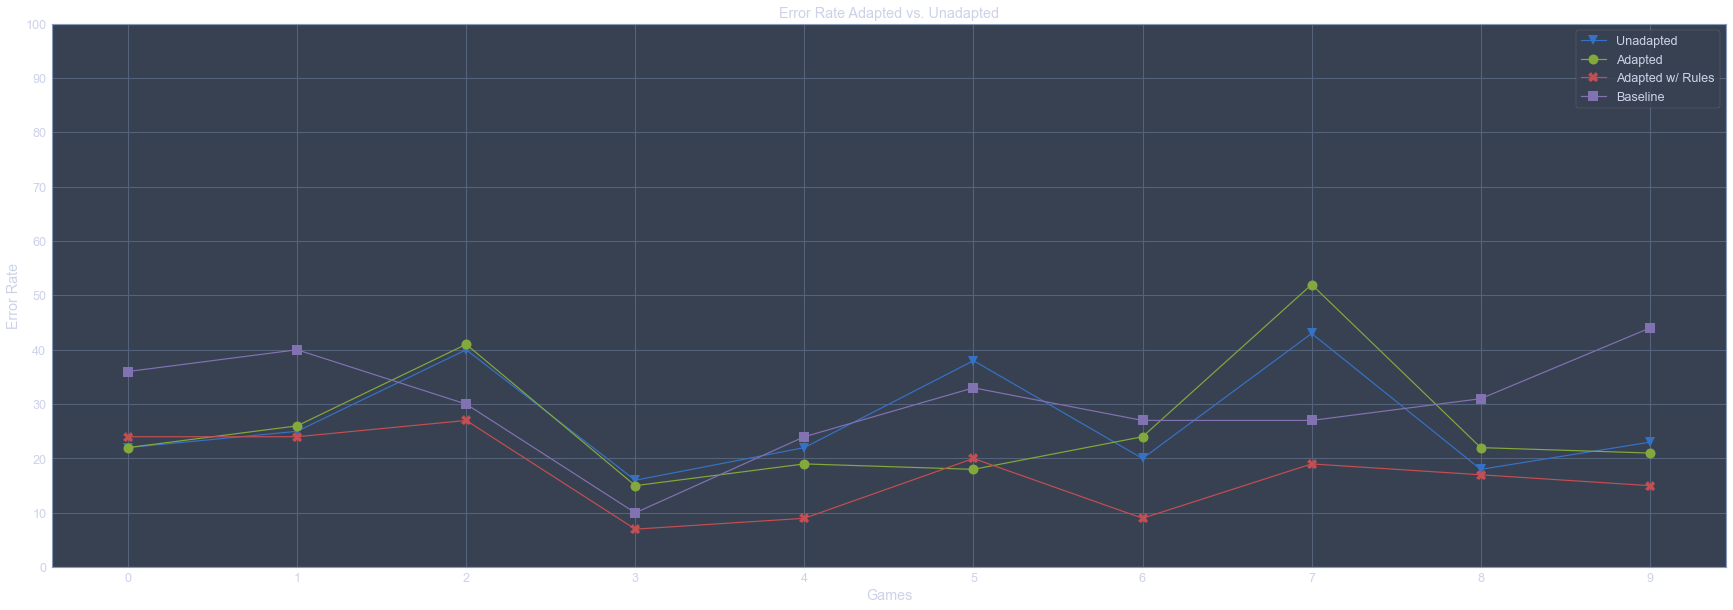

In [14]:
fig = plt.figure(figsize=(30, 10))
plt.plot(unadapted_err, label='Unadapted', marker='v', markersize=10)
plt.plot(adapted_err, label='Adapted', marker='o', markersize=10)
plt.plot(adapted_wrules_err, label='Adapted w/ Rules', marker='X', markersize=10)
plt.plot(baseline, label='Baseline', marker='s', markersize=10)
plt.title("Error Rate Adapted vs. Unadapted")
plt.ylabel("Error Rate")
plt.xlabel("Games")
plt.yticks(np.arange(0, 110, 10))
plt.xticks(np.arange(0, 10, 1))
plt.legend()
plt.show()